### Development environment

This guide builds on the `Quickstart Guide` from the Readme of https://github.com/FraunhoferMEVIS/MedicalMultitaskModeling.

First, MMM needs to be installed. There are many options. With a local checkout you can use:

```bash
# For small experiments pip can be used with extra "interactive"
pip install ./medicalmultitaskmodeling[interactive]
# Alternatively, with editable install from local folder
pip install -e ./medicalmultitaskmodeling[interactive]
```

In [ ]:
# %pip install -e ./medicalmultitaskmodeling[interactive]
import torch; import os; from pathlib import Path
# This one-line import encapsulates everything relevant to interactive programming.
from mmm.interactive import configs as cfs, data, tasks, training, pipes, blocks

In [ ]:
# Most experiments need the same stuff.
# This object reads our standard environment variables and prepares for distributed training if torchrun is used.
env = cfs.EnvByConvention("quickstart").if_torchrun_prepare()

## Config

- By convention, we collect the parameters that should be configurable without code changes into a `HyperParameters` object
  - If your experiment wants to examine the impact of different encoders, it might make sense to include an encoder into the config object
- All objects in the library have config options implemented with pydantic

In [ ]:
class HyperParameters(cfs.ExperimentHyperParameters):
    encoder: blocks.PyramidEncoder.Config = blocks.PyramidEncoder.Config(
        model=cfs.TorchVisionCNN.Config(variant="resnet18"),
    )


VSCode provides auto-completion for all configuration options via JSON schema. If it does not exist, this command will create it. However, you must manually add the printed snippet to your settings as instructed by the output.

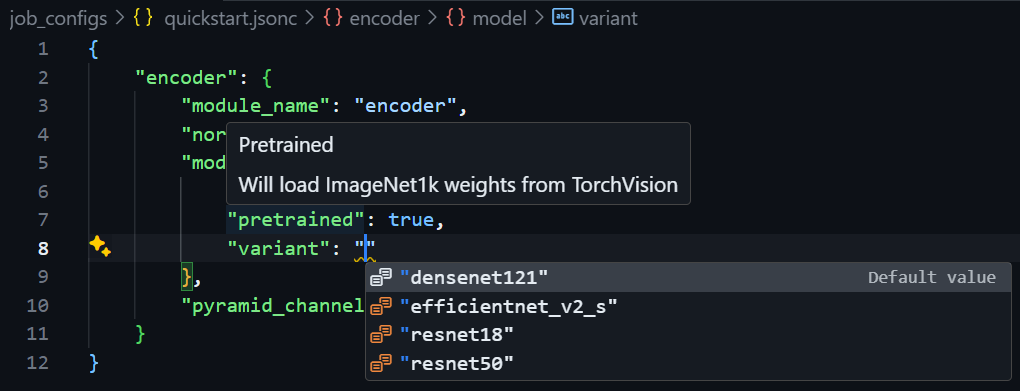

In [ ]:
HyperParameters.update_schema(env)

In [ ]:
# In interactive environments the config is loaded from a file that is always located at ./job_configs/env_name.jsonc
config = HyperParameters.load_config(env)

## Anatomy of a multi-task model

- Our multi-task models consist of shared blocks (see `blocks.SharedBlock`) and tasks (see `tasks.MTLTask`)
- All blocks and tasks are PyTorch modules
- We start with classification. A classification task requires
  - a `blocks.PyramidEncoder` which transforms an image Tensor[C, H, W] into feature maps list[Tensor[C, H, W]]
  - a `blocks.Squeezer` which transforms the feature maps list[Tensor[C, H, W]] into a latent representation Tensor[C, H, W]
  - a `tasks.ClassificationTask` which takes a latent representation, make predictions, and visualizes results

In [ ]:
encoder = blocks.PyramidEncoder(args=config.encoder)
squeezer = blocks.Squeezer(
    blocks.Squeezer.Config(out_channels=64),
    encoder.get_feature_pyramid_channels(),
    encoder.get_strides()
)

# Inputs are batches of images like (batch_size, channels, height, width) which are between 0 and 1.
with torch.no_grad():
    test_input = torch.rand(2, 3, 64, 64)
    feature_maps = encoder(test_input)
    latent_representation = squeezer(feature_maps)
    print("\n".join([f"{feat_map.shape}" for feat_map in feature_maps]), f"\nLatent: {latent_representation.shape}")

## Logging

For confidential data you should use an internal WANDB instance using `%env WANDB_BASE_URL=http://your-host:PORT/`
Or turn it off entirely using `%env WANDB_MODE=offline`
For logging to the official servers (including some of your training images by default), create an account at https://wandb.ai/ and be ready to paste your key into here.

The logging is integrated with our config system. All your user-configurable settings should be visible in the overview of the respective experiment:

In [ ]:
wandb_run = config.init_experiment(env)

If everything worked, you should be able to click a link with a randomly generated name for this experiment.
For now, this link should contain:

- your custom config in Workspace->report
- a structured overview of all your config values in Overview->Config

## Preparing data

In this guide, we will start multi-task classification trainings with the https://medmnist.com/ database.
You can install the database using `pip install medmnist`

In [ ]:
try:
    from medmnist import BloodMNIST
except ImportError:
    %pip install medmnist
    from medmnist import BloodMNIST
# Folder with enough space for input data. If /host-home is not mounted in devcontainer.json, this will be ephemeral.
DATA_ROOT = os.getenv("ML_docker_input_path", default="/host-home/data_root/")
train_dataset = BloodMNIST(root=DATA_ROOT, split="train", download=True, size=224)
val_dataset = BloodMNIST(root=DATA_ROOT, split="val", download=True, size=224)
train_dataset[0], train_dataset.info['label']

MMM uses [PyTorch dataloading](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) with a specific format. Each new dataset needs to be converted into this dictionary-based format. The MedMNIST dataset has a fixed length. In consequence, we could use a `torch.utils.data.Dataset` to wrap it. However, MedMNIST dataset already support `__len__` and `__getitem__` and can directly be used within MMM because of PyTorch duck-typing.

In [ ]:
import torchvision.transforms.functional as F

def transform_pil_to_mmm(case: tuple):
    """
    MMM datasets are wrappers around PyTorch datasets that require a very specific format for each type of label.
    For classification, a dictionary with "image" and "class" keys is expected.
    """
    pil_image, label = case
    return {
        "image": F.to_tensor(pil_image.convert("RGB")),
        "class": label.item()
    }

# The data is encapsulated in an object that holds a training and a validation set.
mmm_cohort = data.TrainValCohort(
    data.TrainValCohort.Config(batch_size=(8, 8), num_workers=1), # 8 train, 8 val
    train_ds=data.ClassificationDataset(
        train_dataset,
        src_transform=transform_pil_to_mmm,
        batch_transform=pipes.Alb(pipes.get_weak_default_augs()), # Augmentations are applied only to training.
        class_names=sorted(list(train_dataset.info['label']))
    ),
    val_ds=data.ClassificationDataset(
        val_dataset,
        src_transform=transform_pil_to_mmm,
        class_names=sorted(list(val_dataset.info['label']))
    ),
)
mmm_train_dataset = mmm_cohort.datasets[0]
mmm_training_case = mmm_train_dataset[0]
mmm_training_case['image'].shape, mmm_training_case["class"]

## Training your model

`training.MTLTrainer` is responsible for running the multi-task training loop. By default, it uses gradient accumulation to perform update steps consisting of all tasks that were added using `trainer.add_mtl_task(...)`. By default, it starts with a validation loop and runs each loop until exhaustion. The last step of a task might consist of a batch with smaller batchsize than the other steps.

In [ ]:
trainer: training.MTLTrainer = training.MTLTrainer(
    training.MTLTrainer.Config(
        checkpoint_cache_folder="trainer_checkpoints",  # by default, config->result=true jobs will be resumed
        train_device="cuda", # "cuda" or "cpu"
        optim=config.example_cnn_optim
    ),
    experiment_name=cfs.remove_wandb_special_chars(config.experiment_name),
    clear_checkpoints=not config.resumable,
).add_shared_blocks([encoder, squeezer])

Each `tasks.MTLTask` assembles its own architecture consisting of its own modules and the shared blocks. In the case of the `tasks.ClassificationTask`, these shared blocks are the shared encoder and the shared squeezer. Each `tasks.MTLTask` needs a unique name.

In [ ]:
mmm_task = tasks.ClassificationTask(
    hidden_dim=squeezer.get_hidden_dim(), args=tasks.ClassificationTask.Config(module_name="unique_task_name"), cohort=mmm_cohort
)

trainer.add_mtl_task(mmm_task)

In [ ]:
trainer.fit()

## Exporting the model

For different use cases we recommend different export methods:

- Native PyTorch export via `MTLTrainer.save_blocks_native`. This exports an `nn.ModuleDict` object which is expected by our inference utilities. This has the disadvantage that all dependencies have to be installed exactly as they were during the export because this uses `pickle` internally. This method is recommended when you have control over the inference environment (e.g. by using the same container as during training).
- ONNX export via `SharedBlock.export_to_onnx`. This exports a single shared block such as the encoder using the established ONNX standard. This is good for sharing with external users.

In [ ]:
# The trainer exports the modules in their current state. If you want to load a checkpoint first:
# trainer.load_checkpoint(Path("trainer_checkpoints/bigtraining42/bestbyvalidation-3"), load_optim_state=False)
# By default, there should be trainer_checkpoints/[experiment-name]/bestbyvalidation-[epoch] and latest folders.

# Cohorts often should not be exported, `only_inference` strips those.
module_dict = trainer.save_blocks_native(Path("./all_blocks.pt"), only_inference=True)
module_dict.keys()

In [ ]:
# Loading requires only one line of torch and is not specific to MMM:
exported_dict = torch.load("./all_blocks.pt")
with torch.inference_mode():
    some_feature_maps = exported_dict["encoder"](test_input)
    print(some_feature_maps[-1].shape)

The native PyTorch export requires the user to know how to assemble the blocks together. Alternatively, native export of individual tasks can be used to export a whole task's pipeline including the shared blocks. For this, the `save_task_native` of `MTLTrainer` can be used.

In [ ]:
trainer.save_task_native("unique_task_name", Path("./task.pt"), only_inference=True)

In [ ]:
# Loading again only requires one line and is not specific to MMM:
exported_task = torch.load("./task.pt")
with torch.inference_mode():
    # The task module returns the logits, torch.argmax is used to get the class index for classification.
    task_output = exported_task.forward(
        (test_input.to(exported_task.task.torch_device), multiple_instance_learning_indices := None)
    )
    # This differs for label types. For example, segmentation tasks have methods for transforming the network output:
    # SemSegTask.logits_to_probas -> SemSegTask.probas_to_preds
    # Useful resources for this are the task's docstring, and `training_step` and visualization methods.